# Project: WeRateDogs Tweet Analysis

#### Table of content
1. [Import Dependencies](#Id)
2. [Data Gathering](#DG)
3. [Assessing Data](#AD)
4. [Data Cleaning](#DC)
5. [Data Analysis](#DA)

## Import Dependencies<a id="Id"></a>

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
%matplotlib inline
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

## Data Gathering<a id="DG"></a>
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
df_archive = pd.read_csv("twitter-archive-enhanced.csv")

In [3]:
df_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [4]:
df_archive.shape

(2356, 17)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
df_pred = pd.read_csv("image_predictions.tsv", sep= "\t")

In [6]:
df_pred.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [7]:
df_pred.shape

(2075, 12)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [8]:
import tweepy

In [30]:
id_list = list(df_archive.tweet_id)
len(id_list)

2356

In [10]:
twitter_data = []
with open("tweet_json.txt","r") as file:
    for line in file:
        data =json.loads(line)
        twitter_data.append({
                             "tweet_id": data["id"],
                             "retweeted": data["retweeted"],
                             "retweets": data["retweet_count"],
                             "favorites": data["favorite_count"],
                            }
                           )
            

In [11]:
twitter_data[:3]

[{'tweet_id': 892420643555336193,
  'retweeted': False,
  'retweets': 7024,
  'favorites': 33861},
 {'tweet_id': 892177421306343426,
  'retweeted': False,
  'retweets': 5304,
  'favorites': 29360},
 {'tweet_id': 891815181378084864,
  'retweeted': False,
  'retweets': 3488,
  'favorites': 22084}]

In [12]:
columns = list(twitter_data[0].keys())

In [13]:
df_twt = pd.DataFrame(twitter_data, columns=columns)

In [14]:
df_twt.head(1)

,tweet_id,retweeted,retweets,favorites
0,892420643555336193,False,7024,33861


In [15]:
df_twt.shape

(2327, 4)

In [37]:
!ls

act_report.html        twitter-archive-enhanced.csv  wrangle_report.html
image_predictions.tsv  twitter_archive_master.csv
tweet_json.txt	       wrangle_act.ipynb


## Assessing Data<a id="AD"></a>


In [16]:
# Make copies of original pieces of data
df_archive_copy = df_archive.copy()
df_pred_copy = df_pred.copy()
df_twt_copy = df_twt.copy()

In [17]:
df_archive_copy.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [29]:
df_archive_copy[df_archive_copy["retweeted_status_id"].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [30]:
df_archive_copy[df_archive_copy["retweeted_status_id"].notnull()].shape

(181, 17)

There are 181 retweet rows in the dataframe

In [23]:
df_archive_copy.shape

(2356, 17)

In [31]:
df_pred_copy.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [32]:
df_pred_copy.shape

(2075, 12)

In [33]:
df_twt_copy.head()

,tweet_id,retweeted,retweets,favorites
0,892420643555336193,False,7024,33861
1,892177421306343426,False,5304,29360
2,891815181378084864,False,3488,22084
3,891689557279858688,False,7236,36985
4,891327558926688256,False,7775,35361


In [34]:
df_twt_copy.retweeted.value_counts()

False    2327
Name: retweeted, dtype: int64

There is no retweet row in the dataframe

In [35]:
df_twt_copy.shape

(2327, 4)

- Analysis Data are in different Dataframes. Should be merged to one and collectively assessed

In [36]:
# join all dataframes
df_master = pd.merge(df_archive_copy,df_pred_copy, on = "tweet_id", how = "inner")
df_master = pd.merge(df_master, df_twt_copy, on = "tweet_id", how = "inner")

In [42]:
df_master

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweeted,retweets,favorites
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,False,7024,33861
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,False,5304,29360
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,False,3488,22084
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,False,7236,36985
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,False,7775,35361
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False,False,2603,17835
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False,False,1672,10381
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True,False,15784,56909
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,False,3628,24553
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href="

- Not all tweet are predicted as Dog

In [37]:
df_master.source.unique()

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

- Source column data entfry carries html tags

In [27]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 31 columns):
tweet_id                      2057 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2057 non-null object
source                        2057 non-null object
text                          2057 non-null object
retweeted_status_id           71 non-null float64
retweeted_status_user_id      71 non-null float64
retweeted_status_timestamp    71 non-null object
expanded_urls                 2057 non-null object
rating_numerator              2057 non-null int64
rating_denominator            2057 non-null int64
name                          2057 non-null object
doggo                         2057 non-null object
floofer                       2057 non-null object
pupper                        2057 non-null object
puppo                         2057 non-null object
jpg_url                       2057 

In [43]:
df_master.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2034
in_reply_to_user_id           2034
timestamp                        0
source                           0
text                             0
retweeted_status_id           1986
retweeted_status_user_id      1986
retweeted_status_timestamp    1986
expanded_urls                    0
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
jpg_url                          0
img_num                          0
p1                               0
p1_conf                          0
p1_dog                           0
p2                               0
p2_conf                          0
p2_dog                           0
p3                               0
p3_conf                          0
p3_dog                           0
retweeted           

- There are **Missing data** in 5 columns
- Tweet_id is **int datatype** instead of **object**
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id are **floats** instead of **object** datatype
- timestamp and retweeted_status_timestamp should be **datetime** instead of **object**
- **Complex documentation** in doggo,floofer,pupper,puppo should be accounted for as 1 column instead of 4
- **Cumbersome entry** associated with prediction. Not definite prediction Data

In [45]:
df_master.duplicated().sum()

0

In [38]:
df_master.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,retweets,favorites
count,2.057000e+03,2.300000e+01,2.300000e+01,7.100000e+01,7.100000e+01,2057.000000,2057.00000,2057.000000,2057.000000,2.057000e+03,2.057000e+03,2057.000000,2057.000000
mean,7.377684e+17,6.978112e+17,4.196984e+09,7.609110e+17,1.109101e+16,12.265921,10.51580,1.204181,0.594274,1.348003e-01,6.042487e-02,2367.961595,7453.452115
std,6.756840e+16,4.359384e+16,0.000000e+00,5.824295e+16,9.345452e+16,40.857799,7.20826,0.563240,0.271223,1.007304e-01,5.100092e-02,4139.902278,11278.995452
min,6.660209e+17,6.671522e+17,4.196984e+09,6.675094e+17,7.832140e+05,0.000000,2.00000,1.000000,0.044333,1.011300e-08,1.740170e-10,11.000000,0.000000
25%,6.762374e+17,6.732411e+17,4.196984e+09,7.096529e+17,4.196984e+09,10.000000,10.00000,1.000000,0.363272,5.390140e-02,1.624560e-02,503.000000,1411.000000
50%,7.110080e+17,6.757073e+17,4.196984e+09,7.761133e+17,4.196984e+09,11.000000,10.00000,1.000000,0.587764,1.186470e-01,4.948690e-02,1119.000000,3257.000000
75%,7.928838e+17,7.031489e+17,4.196984e+09,7.956132e+17,4.196984e+09,12.000000,10.00000,1.000000,0.843911,1.959500e-01,9.219820e-02,2728.000000,9292.000000
max,8.924206e+17,8.558181e+17,4.196984e+09,8.768508e+17,7.874618e+17,1776.000000,170.00000,4.000000,1.000000,4.880140e-01,2.734190e-01,70886.000000,145089.000000


- The min and max values of  both rating_numerator and rating_ shows that there are **anomalies** in the entry data of both columns when compared with the their mean values

further probe: Make scatter plot for both columns to check data distribution

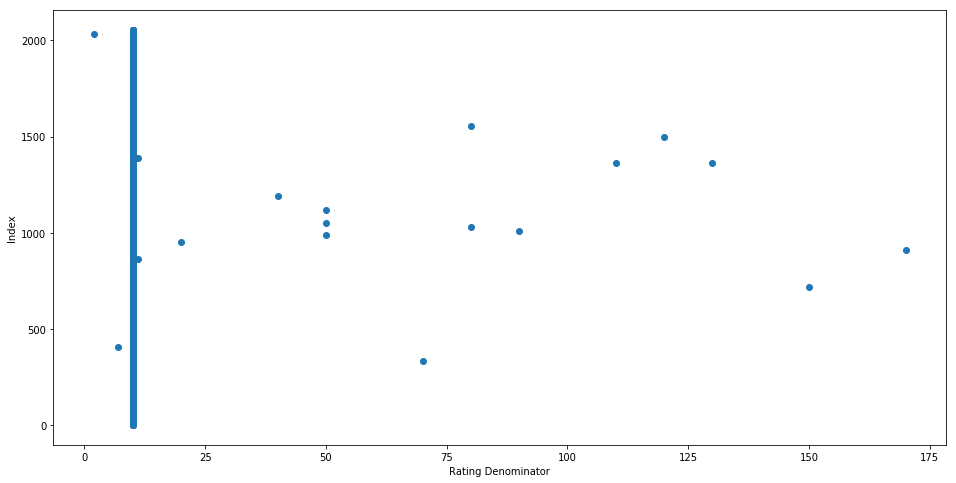

In [39]:
plt.figure(figsize=[16,8])
plt.scatter(x=df_master.rating_denominator,y=df_master.index)
plt.xlabel("Rating Denominator")
plt.ylabel("Index");

- There are **outliers** in the rating_denominator column

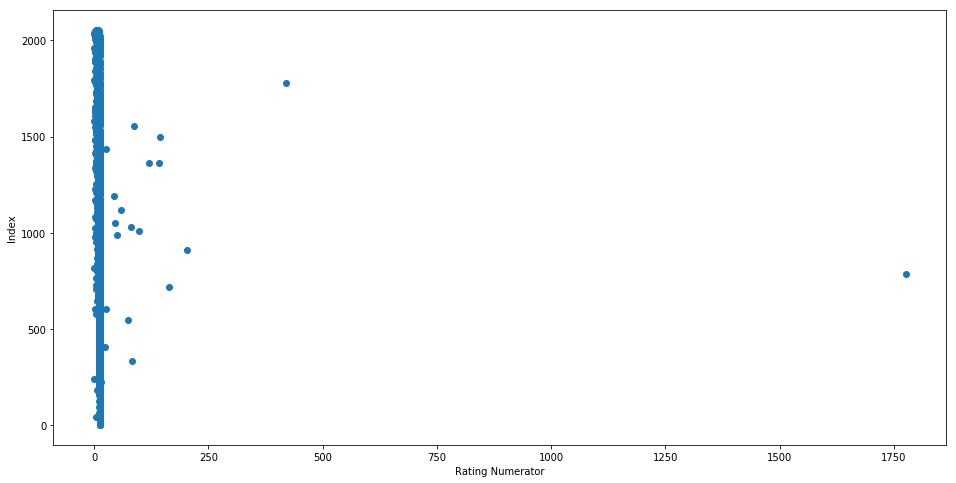

In [40]:
plt.figure(figsize=[16,8])
plt.scatter(x=df_master.rating_numerator,y=df_master.index);
plt.xlabel("Rating Numerator")
plt.ylabel("Index");

- There are **outliers** that are far from the standard rating in the rating_numerataor column

In [41]:
df_master["retweeted"].value_counts() #Checks if there is a row associated with tweets

False    2057
Name: retweeted, dtype: int64

- The retweeted column holds no valuable info

### Quality issues
1. There are Missing data in 5 columns
2. Tweet_id is int datatype instead of object
3. in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,retweeted_status_user_id are floats instead of object datatype
4. timestamp and retweeted_status_timestamp should be datetime instead of object
5. Cumbersome entry associated with prediction. No definite prediction Data
6. There are outliers in the rating_denominator column
7. There are outliers that are far from the standard rating in the rating_numerataor column
8. The retweeted column holds no valuable info
9. Not all tweets are predicted as Dog

### Tidiness issues
1. Source column data entfry carries html tags
2. Complex documentation in doggo,floofer,pupper,puppo should be accounted for as 1 column instead of 4

## Data Cleaning<a id="DC"></a>

### Cleaning Steps
1. Make a copy of the master dataframe
2. Drop columns that holds reply detail
4. Convert columns to appropriate datatypes
5. Merge doggo, floofer, pupper, puppo into one column (doggolingo)
6. Assess the tweets associated with rating_denominator anomaly. Drop if it's not a rating
7. Assess the tweets associated with rating_numerator anomaly, drop if it's not a rating, modify if its a rating.
8. Eliminate the html syntax in source columnn by replacing it with a clean input
9. Get only rows with at least one True dog prediction
9. Get the breed from the best possible prediction and confidence
10. Reduce the columns associated with prediction to two (breed and prediction confidence level)
10. Drop  columns and rows that associated with retweet

#### 1. Make a copy of the master dataframe

In [158]:
df_master_copy = df_master.copy()

#### 2. There are Missing data in 5 columns

Drop columns with missing data that holds reply informations

In [159]:
df_master_copy.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2034
in_reply_to_user_id           2034
timestamp                        0
source                           0
text                             0
retweeted_status_id           1986
retweeted_status_user_id      1986
retweeted_status_timestamp    1986
expanded_urls                    0
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
jpg_url                          0
img_num                          0
p1                               0
p1_conf                          0
p1_dog                           0
p2                               0
p2_conf                          0
p2_dog                           0
p3                               0
p3_conf                          0
p3_dog                           0
retweeted           

In [160]:
df_master_copy.drop(['in_reply_to_status_id','in_reply_to_user_id'],
                   axis=1, inplace = True)

In [161]:
df_master_copy.isnull().sum()

tweet_id                         0
timestamp                        0
source                           0
text                             0
retweeted_status_id           1986
retweeted_status_user_id      1986
retweeted_status_timestamp    1986
expanded_urls                    0
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
jpg_url                          0
img_num                          0
p1                               0
p1_conf                          0
p1_dog                           0
p2                               0
p2_conf                          0
p2_dog                           0
p3                               0
p3_conf                          0
p3_dog                           0
retweeted                        0
retweets                         0
favorites           

#### 3. The retweeted column holds no valuable info

 Drop columns that associated with retweet

In [162]:
df_master_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweeted', 'retweets', 'favorites'],
      dtype='object')

In [163]:
df_master_copy.drop(["retweeted"], axis=1,inplace=True)

In [164]:
df_master_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggo', 'floofer', 'pupper', 'puppo', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'retweets', 'favorites'],
      dtype='object')

#### 4. Wrong Datatypes

Convert Affected Columns to appropriate datatypes

In [165]:
df_master_copy.dtypes

tweet_id                        int64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
jpg_url                        object
img_num                         int64
p1                             object
p1_conf                       float64
p1_dog                           bool
p2                             object
p2_conf                       float64
p2_dog                           bool
p3                             object
p3_conf                       float64
p3_dog                           bool
retweets    

In [166]:
df_master_copy["tweet_id"] = df_master_copy["tweet_id"].astype("str")
df_master_copy["timestamp"] = pd.to_datetime(df_master_copy["timestamp"])
df_master_copy["retweeted_status_timestamp"] = pd.to_datetime(
                                            df_master_copy["retweeted_status_timestamp"])


In [167]:
print(df_master_copy["tweet_id"].dtype)
print(df_master_copy["timestamp"].dtype)
print(df_master_copy["retweeted_status_timestamp"].dtype)

object
datetime64[ns]
datetime64[ns]


#### 5.  Complex documentation in doggo,floofer,pupper,puppo should be accounted for as 1 column instead of 4

Merge doggo, floofer, pupper, puppo into one column (doggolingo)

In [168]:
df_master_copy["doggo"].replace("None","emp",inplace = True)
df_master_copy["floofer"].replace("None","emp",inplace = True)
df_master_copy["pupper"].replace("None","emp",inplace = True)
df_master_copy["puppo"].replace("None","emp",inplace = True)
#"None" is an inbuilt word in python that can not be used on the .query function, hence we replace it with a "emp"

In [169]:
#separates dataframes that holds each of the doggolingo values
doggo = df_master_copy[df_master_copy["doggo"] == "doggo"]
floofer = df_master_copy[df_master_copy["floofer"] == "floofer"]
pupper = df_master_copy[df_master_copy["pupper"] == "pupper"]
puppo = df_master_copy[df_master_copy["puppo"] == "puppo"]

In [170]:
#creates dataframe that holds none of the doggolingo value
emp_df = df_master_copy.query("doggo == 'emp' and floofer == 'emp' and pupper == 'emp' and puppo== 'emp'")

In [171]:
emp_df.shape

(1739, 28)

In [172]:
#renames each of the doggolingo-related columns to doggolingo
doggo.rename(columns={"doggo":"doggolingo"}, inplace=True)
floofer.rename(columns={"floofer":"doggolingo"}, inplace=True)
puppo.rename(columns={"puppo":"doggolingo"}, inplace=True)
pupper.rename(columns={"pupper":"doggolingo"}, inplace=True)
emp_df.rename(columns={"doggo":"doggolingo"}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [173]:
#drop other doggolingo-related columns
doggo.drop(['floofer', 'pupper', 'puppo'], axis=1, inplace=True)
floofer.drop(['doggo', 'pupper', 'puppo'], axis=1, inplace=True)
puppo.drop(['doggo', 'floofer', 'pupper',], axis=1, inplace=True)
pupper.drop(['doggo', 'floofer', 'puppo'], axis=1, inplace=True)
emp_df.drop(['floofer', 'pupper', 'puppo'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [174]:
#concatenates the earlier separated dataframes
df_master_copy = pd.concat([emp_df,floofer,doggo,puppo,pupper],sort=False)

In [175]:
df_master_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggolingo', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweets',
       'favorites'],
      dtype='object')

In [176]:
df_master_copy.doggolingo.value_counts()

emp        1739
pupper      221
doggo        78
puppo        24
floofer       8
Name: doggolingo, dtype: int64

In [177]:
df_master_copy.doggolingo.replace("emp","None", inplace=True) #Restore None

#### 6. There are outliers in the rating_denominator column

Assess the tweets associated with rating_denominator anomaly. Drop if it's not a rating

In [178]:
df_master_copy[df_master_copy["rating_denominator"] != 10]

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggolingo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites
335,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,https://pbs.twimg.com/media/C2OtWr0VQAEnS9r.jpg,2,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True,3007,11604
405,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaT,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True,1339,5064
720,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaT,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,https://pbs.twimg.com/ext_tw_video_thumb/75846...,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True,2032,4483
861,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,https://pbs.twimg.com/media/CkZVdJ6WYAAXZ5A.jpg,3,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True,12158,32638
909,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,https://pbs.twimg.com/media/CiWWhVNUYAAab_r.jpg,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False,1146,3557
952,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,https://pbs.twimg.com/media/CgiFjIpWgAA4wVp.jpg,1,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True,1444,3783
986,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,https://pbs.twimg.com/media/CfFNk7cWAAA-hND.jpg,1,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True,191,2205
1007,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's 9 puppers on a bench. 99...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/713900603...,99,90,None,None,https://pbs.twimg.com/media/CehIzzZWQAEyHH5.jpg,1,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True,666,2629
1032,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" r...",Here's a brigade of puppers. All look very pre...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/710658690...,80,80,None,None,https://pbs.twimg.com/media/CdzETn4W4AAVU5N.jpg,1,soft-coated_wheaten_terrier,0.948617,True,Dandie_Dinmont,0.018664,True,cairn,0.015943,True,516,2147
1050,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" r...","From left to right:\nCletus, Jerome, Alejandro...",NaN,NaN,NaT,https://twitter.com/dog_rates/status/709198395...,45,50,None,None,https://pbs.twimg.com/media/CdeUKpcWoAAJAWJ.jpg,1,borzoi,0.490783,True,wire-haired_fox_terrier,0.083513,True,English_setter,0.083184,True,591,2276

In [179]:
df_master_copy[df_master_copy["tweet_id"] == '810984652412424192']["text"]

405    Meet Sam. She smiles 24/7 &amp; secretly aspir...
Name: text, dtype: object

- Only https://twitter.com/dog_rates/status/810984652412424192 is not a rating. Hence, drop.

In [180]:
df_master_copy.drop([405], axis=0,inplace=True)

In [181]:
df_master_copy.reset_index(drop=True, inplace= True)

#### 7. There are outliers that are far from the standard rating in the rating_numerataor column

Assess the tweets associated with rating_numerator anomaly, drop if it's not a rating, modify if its a rating.

In [182]:
x = df_master_copy.query("rating_numerator > 14 or rating_denominator != 10")

In [183]:
x.index

Int64Index([ 192,  277,  451,  599,  647,  706,  743,  776,  804,  824,  847,
             864,  920,  983, 1116, 1117, 1135, 1173, 1220, 1269, 1460, 1717,
            1888],
           dtype='int64')

In [184]:
for i in list(df_master_copy.query("rating_numerator > 14 or rating_denominator != 10").index):
    print(i," is: \n" ,df_master_copy.loc[i,"text"], "\n" )

192  is: 
 RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI 

277  is: 
 The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 

451  is: 
 This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 

599  is: 
 Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 

647  is: 
 This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh 

706  is: 
 After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 

743  is: 
 Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv 

776  is: 
 Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 

804  is: 
 This is Bluebert. He just saw that both #FinalFur match ups are split 50/5

In [185]:
x.index

Int64Index([ 192,  277,  451,  599,  647,  706,  743,  776,  804,  824,  847,
             864,  920,  983, 1116, 1117, 1135, 1173, 1220, 1269, 1460, 1717,
            1888],
           dtype='int64')

- Assesssing each tweet via the expanded url, each tweet index will be classed according to the proper action to be taken
Most of the ratings in the outliers are ratings of more than one dogs.Hence we will replace each of the ratings with an average score.
###### Drop
-  1460 is a dogg named SnoopDogg :)
- 647 not a regular rating

In [186]:
# creates dictionary of affected row index and the corresponding valid rating
mod_dict = { 192:15,  277:12,  451:9.75,  599:11,  706:14,  743:12,  776:13,  804:11,  824:11,
847:10,  864:9,  920:12,  983:11, 1116:11, 1117:11, 1135:10, 1173:11.26,
 1220:12, 1269:11, 1717:9, 1888:11.27}

In [187]:
len(mod_dict)

21

In [188]:
#replace affected rows with corresponding rating

In [189]:
for i in mod_dict:
    df_master_copy.loc[i,"rating_numerator"] = mod_dict[i] 

In [190]:
df_master_copy.drop([1460,647], axis= 0, inplace = True)
# drop the rows with invalid ratings

In [191]:
df_master_copy.rating_numerator.value_counts()

12.00    482
10.00    428
11.00    422
13.00    278
9.00     152
8.00      95
7.00      51
14.00     39
5.00      35
6.00      32
3.00      19
4.00      15
2.00       9
1.00       4
0.00       2
15.00      1
11.27      1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

In [192]:
df_master_copy.reset_index(inplace= True, drop=True) 

In [193]:
df_master_copy["rating_denominator"] = 10 # fill all denominator with 10

#### 8. Source column data entfry carries html tags

Eliminate the html syntax in source columnn by replacing it with a clean input

In [194]:
df_master_copy.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2028
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>       9
Name: source, dtype: int64

In [195]:
df_master_copy.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
                              ,"Twitter for iPhone", inplace = True)

df_master_copy.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>'
                              ,"Vine - Make a Scene", inplace = True)

df_master_copy.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>'
                              ,"Twitter Web Client", inplace = True)

df_master_copy.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'
                              ,"TweetDeck", inplace = True)

In [196]:
df_master_copy.source.value_counts()

Twitter for iPhone    2028
Twitter Web Client      30
TweetDeck                9
Name: source, dtype: int64

#### 9. Not all Tweets are dogs

Get only rows with at least one True dog prediction

In [197]:
df_master_copy.head(5)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggolingo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7024,33861
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,5304,29360
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,3488,22084
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7236,36985
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,7775,35361


In [198]:
notdog = df_master_copy.query("p1_dog == False and p2_dog== False and p3_dog == False") #predictions that are not dogs
notdog.head(5)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggolingo,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweets,favorites
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,7024,33861
18,887517139158093824,2017-07-19 03:39:09,Twitter for iPhone,I've yet to rate a Venezuelan Hover Wiener. Th...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/887517139...,14.0,10,such,None,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False,9864,40778
24,886680336477933568,2017-07-16 20:14:00,Twitter for iPhone,This is Derek. He's late for a dog meeting. 13...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/886680336...,13.0,10,Derek,None,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False,3745,19768
43,881268444196462592,2017-07-01 21:49:04,Twitter for iPhone,Meet Elliot. He's a Canadian Forrest Pup. Unus...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/881268444...,12.0,10,Elliot,None,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False,4501,20504
44,880935762899988482,2017-06-30 23:47:07,Twitter for iPhone,This is Louis. He's crossing. It's a big deal....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/880935762...,13.0,10,Louis,None,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False,2337,15071


In [199]:
df_master_copy.drop(notdog.index, axis=0, inplace = True) #Dropping all rows that are not predicted as dog using index 

In [200]:
df_master_copy.shape

(1747, 25)

#### 10. Cumbersome entry associated with prediction. No definite prediction Data

- Get the breed from the best possible prediction and confidence 
- Reduce the columns associated with prediction to two (breed and prediction confidence level)

In [201]:
df_master_copy.reset_index(drop=True, inplace=True)

In [202]:
breeds = []
for ind,x in enumerate(df_master_copy["p1_dog"]):
    if x == True:
        dog_breed = df_master_copy.loc[ind,"p1"]
        conf = df_master_copy.loc[ind,"p1_conf"]
        breeds.append({dog_breed:conf})
    
    elif df_master_copy.loc[ind,"p2_dog"] == True:
        dog_breed = df_master_copy.loc[ind,"p2"]
        conf = df_master_copy.loc[ind,"p2_conf"]
        breeds.append({dog_breed:conf})
    
    elif df_master_copy.loc[ind,"p3_dog"] == True:
        dog_breed = df_master_copy.loc[ind,"p3"]
        conf = df_master_copy.loc[ind,"p3_conf"]
        breeds.append({dog_breed:conf})
    else:
        print("error in", ind)

In [203]:
len(breeds)

1747

In [204]:
#https://stackoverflow.com/questions/54488095/python-3-dictionary-key-to-a-string-and-value-to-another-string
breed = []
conf = []
for i in breeds:
    key,value = (list(i.items())[0])
    breed.append(key)
    conf.append(value)

In [205]:
df_master_copy["breed"]= breed
df_master_copy["conf"] = conf

In [206]:
df_master_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggolingo', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweets', 'favorites',
       'breed', 'conf'],
      dtype='object')

In [207]:
# Drop other dog prediction columns
df_master_copy.drop(['p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace = True)

In [208]:
df_master_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'doggolingo', 'jpg_url', 'img_num', 'retweets', 'favorites', 'breed',
       'conf'],
      dtype='object')

In [209]:
df_master_copy.head()

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggolingo,jpg_url,img_num,retweets,favorites,breed,conf
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,5304,29360,Chihuahua,0.323581
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,3488,22084,Chihuahua,0.716012
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,7236,36985,Labrador_retriever,0.168086
3,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,7775,35361,basset,0.555712
4,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching ...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,None,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,2603,17835,Chesapeake_Bay_retriever,0.425595


In [210]:
df_master_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747 entries, 0 to 1746
Data columns (total 18 columns):
tweet_id                      1747 non-null object
timestamp                     1747 non-null datetime64[ns]
source                        1747 non-null object
text                          1747 non-null object
retweeted_status_id           60 non-null float64
retweeted_status_user_id      60 non-null float64
retweeted_status_timestamp    60 non-null datetime64[ns]
expanded_urls                 1747 non-null object
rating_numerator              1747 non-null float64
rating_denominator            1747 non-null int64
name                          1747 non-null object
doggolingo                    1747 non-null object
jpg_url                       1747 non-null object
img_num                       1747 non-null int64
retweets                      1747 non-null int64
favorites                     1747 non-null int64
breed                         1747 non-null object
conf             

There are retweets Data in the Master DataFrame. Drop Rows then columns associated with retweets

In [211]:
df_master_copy = df_master_copy[df_master_copy["retweeted_status_id"].isnull()]





In [212]:
df_master_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687 entries, 0 to 1746
Data columns (total 18 columns):
tweet_id                      1687 non-null object
timestamp                     1687 non-null datetime64[ns]
source                        1687 non-null object
text                          1687 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null datetime64[ns]
expanded_urls                 1687 non-null object
rating_numerator              1687 non-null float64
rating_denominator            1687 non-null int64
name                          1687 non-null object
doggolingo                    1687 non-null object
jpg_url                       1687 non-null object
img_num                       1687 non-null int64
retweets                      1687 non-null int64
favorites                     1687 non-null int64
breed                         1687 non-null object
conf                

In [217]:
df_master_copy.drop(["retweeted_status_id","retweeted_status_user_id",
                     "retweeted_status_timestamp"], axis=1,inplace=True )

In [218]:
df_master_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687 entries, 0 to 1746
Data columns (total 15 columns):
tweet_id              1687 non-null object
timestamp             1687 non-null datetime64[ns]
source                1687 non-null object
text                  1687 non-null object
expanded_urls         1687 non-null object
rating_numerator      1687 non-null float64
rating_denominator    1687 non-null int64
name                  1687 non-null object
doggolingo            1687 non-null object
jpg_url               1687 non-null object
img_num               1687 non-null int64
retweets              1687 non-null int64
favorites             1687 non-null int64
breed                 1687 non-null object
conf                  1687 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 210.9+ KB


In [219]:
df_master_copy.reset_index(drop=True, inplace=True)

In [220]:
df_master_copy.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggolingo,jpg_url,img_num,retweets,favorites,breed,conf
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,5304,29360,Chihuahua,0.323581
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,3488,22084,Chihuahua,0.716012
2,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,7236,36985,Labrador_retriever,0.168086


In [221]:
df_master_copy.tail(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggolingo,jpg_url,img_num,retweets,favorites,breed,conf
1684,672254177670729728,2015-12-03 03:21:00,Twitter for iPhone,This is Rolf. He's having the time of his life...,https://twitter.com/dog_rates/status/672254177...,11.0,10,Rolf,pupper,https://pbs.twimg.com/media/CVRTmz1WcAA4uMF.jpg,1,654,1277,pug,0.979487
1685,672205392827572224,2015-12-03 00:07:09,Twitter for iPhone,This is Opal. He's a Royal John Coctostan. Rea...,https://twitter.com/dog_rates/status/672205392...,9.0,10,Opal,pupper,https://pbs.twimg.com/media/CVQnPMrVAAAzShR.jpg,1,1012,1999,pug,0.003267
1686,672160042234327040,2015-12-02 21:06:56,Twitter for iPhone,This is Bubba. He's a Titted Peebles Aorta. Ev...,https://twitter.com/dog_rates/status/672160042...,8.0,10,Bubba,pupper,https://pbs.twimg.com/media/CVP9_beUEAAwURR.jpg,1,304,767,pug,0.561027


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [222]:
df_master_copy.to_csv("twitter_archive_master.csv")

In [223]:
!ls

act_report.html        twitter-archive-enhanced.csv  wrangle_report.html
image_predictions.tsv  twitter_archive_master.csv
tweet_json.txt	       wrangle_act.ipynb


## Analyzing and Visualizing Data<a id="DA"></a>

In [224]:
#https://stackoverflow.com/questions/16266019/python-pandas-group-datetime-column-into-hour-and-minute-aggregations
df_master_copy.groupby(df_master_copy.timestamp.dt.hour).count()["tweet_id"]


timestamp
0     226
1     235
2     171
3     139
4      76
5      18
6       3
13      1
14      4
15     77
16    172
17    143
18     82
19     68
20     62
21     60
22     55
23     95
Name: tweet_id, dtype: int64

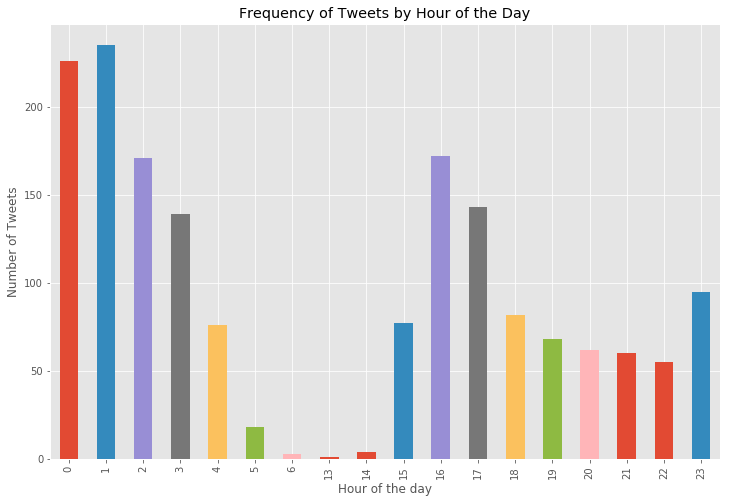

In [225]:
style.use('ggplot')
plt.figure(figsize=(12,8))
df_master_copy.groupby(df_master_copy.timestamp.dt.hour).count()["tweet_id"].plot(kind="bar")
plt.title("Frequency of Tweets by Hour of the Day")
plt.xlabel("Hour of the day")
plt.ylabel("Number of Tweets")
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=15)

- Active between 3pm to 5am
- The Handler is most active at 1 am
- least active between 5am to 3pm
- No rating activity between 7 am to 1pm

In [226]:
temp_df = df_master_copy.copy()
val_count = temp_df['breed'].value_counts() #Gets frequency of each dogs
count_dict = val_count.to_dict() #converts to dictionary
temp_df['breed_freq'] = temp_df['breed'].map(count_dict) #creates a column for total frequency of each breed
#creates dataframe of dog breeds that were rated more than 10 times
top_freq_df= temp_df[temp_df["breed_freq"]>10].reset_index(drop=True) 


In [227]:
temp_df.describe()

,rating_numerator,rating_denominator,img_num,retweets,favorites,conf,breed_freq
count,1687.000000,1687.0,1687.000000,1687.000000,1687.000000,1687.000000,1687.000000
mean,10.833598,10.0,1.215768,2303.165975,8057.809129,0.549969,48.413159
std,1.781843,0.0,0.576044,4179.491427,11847.870753,0.299262,48.319266
min,0.000000,10.0,1.000000,11.000000,66.000000,0.000010,1.000000
25%,10.000000,10.0,1.000000,519.000000,1812.000000,0.303098,12.000000
50%,11.000000,10.0,1.000000,1140.000000,3748.000000,0.550506,25.000000
75%,12.000000,10.0,1.000000,2599.500000,9934.000000,0.822520,91.000000
max,14.000000,10.0,4.000000,70886.000000,145089.000000,0.999956,161.000000


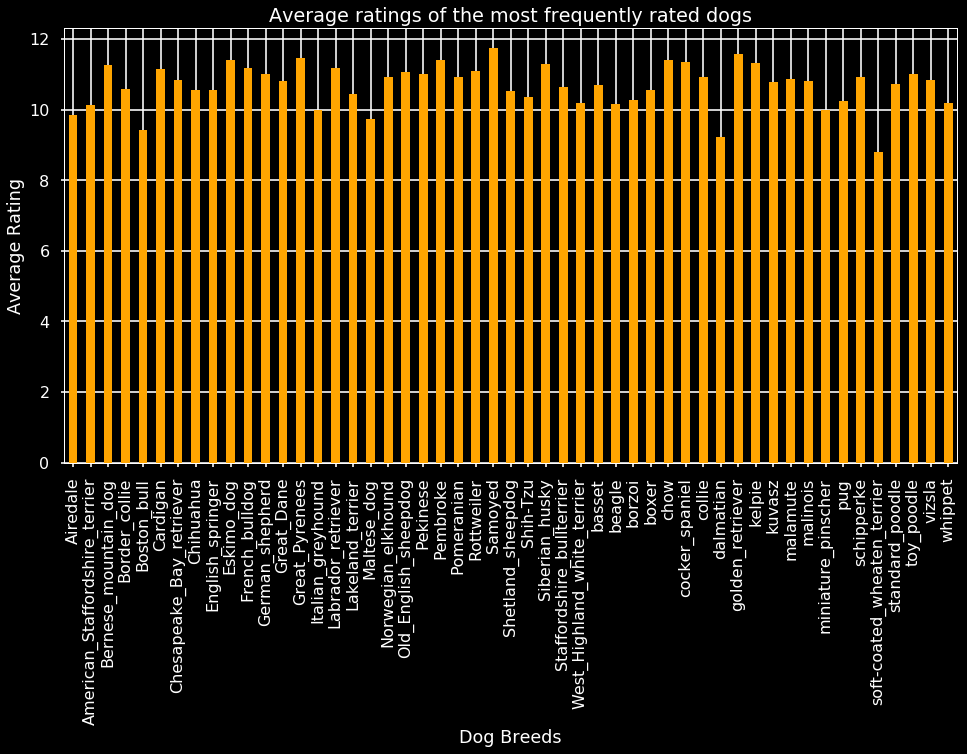

In [235]:
style.use("seaborn-poster")
plt.figure(figsize=(16,8))
top_freq_df.groupby("breed").mean()["rating_numerator"].plot(kind="bar",color="orange")
plt.title("Average ratings of the most frequently rated dogs")
plt.xlabel("Dog Breeds")
plt.ylabel("Average Rating");

- Samoyed is the best rated Dog Breed
- soft-coated-wheaten-terrier is the least rated Dog breed

Tweet Engagement

In [229]:
temp_df["total_engagement"] = temp_df.retweets + temp_df.favorites

In [230]:
top_engagement = temp_df.groupby("breed", as_index=False).mean().sort_values(by="total_engagement",
                                                                            ascending= False).head(20)

In [231]:
least_engagement = temp_df.groupby("breed", as_index=False).mean().sort_values(by="total_engagement",
                                                                            ascending= False).tail(20)

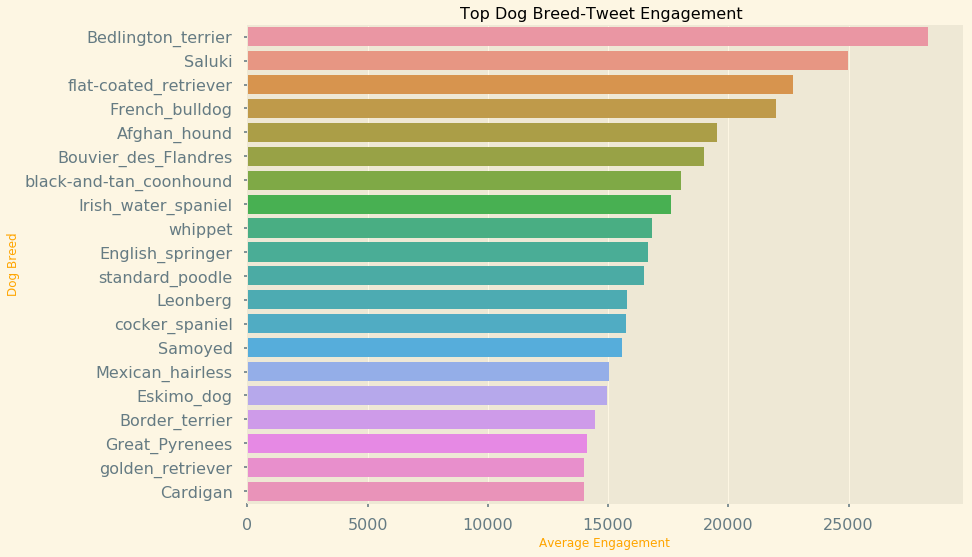

In [232]:
style.use("Solarize_Light2")
sns.barplot(y=top_engagement["breed"],x=top_engagement["total_engagement"], orient = 'h');
plt.title("Top Dog Breed-Tweet Engagement ")
plt.xlabel("Average Engagement", color="Orange")
plt.ylabel("Dog Breed", color="orange");

- Bedlington Terrier is the most engaged Dog breed

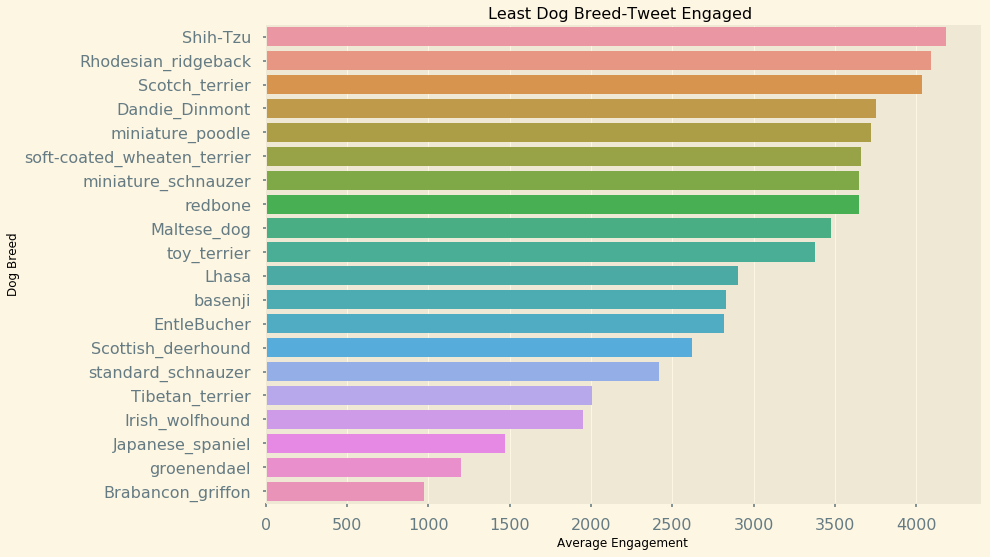

In [233]:
style.use("Solarize_Light2")
sns.barplot(y=least_engagement["breed"],x=least_engagement["total_engagement"], orient = 'h')
plt.title("Least Dog Breed-Tweet Engaged ", color="black")
plt.xlabel("Average Engagement", color="black")
plt.ylabel("Dog Breed", color="black");

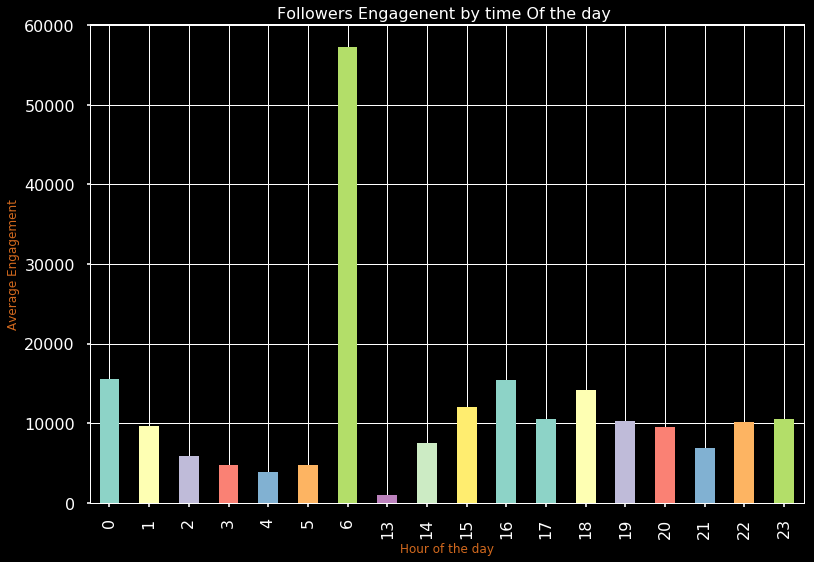

In [234]:
style.use("dark_background")
temp_df.groupby(temp_df.timestamp.dt.hour).mean()["total_engagement"].plot(kind="bar")
plt.title("Followers Engagenent by time Of the day ")
plt.xlabel("Hour of the day", color="chocolate")
plt.ylabel("Average Engagement", color="chocolate");

- @WeRateDogs Followers engage most with tweets made around 6am
- @WeRateDogs Followers engage least with tweets made around 1pm

### Insights:
1. The best period to get the @WeRateDog twitter Account Handler to rate your Dog is between **3pm to 5am**. Best time being **1am**
2. Your Dog is less likely to get rated by the Handler between **5am to 3pm**. Worst time being between **7am to 1pm**
3. **Samoyed** is the best rated Dog Breed
4. **Soft-coated-wheaten Terrier** is the least rated Dog breed
5. Posted tweets rating **Bedlington Terrier** get the best followers enagegement (aggregate of retweets and favorites)
6. Posted tweets Rating **Brabancon Griffon** get the worst followers enagegement (aggregate of retweets and favorites)
7. @WeRateDogs Followers engage most with tweets made around 6am
8. @WeRateDogs Followers engage least with tweets made around 1pm